In [1]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso,Ridge,ElasticNet
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE

from copy import deepcopy
from boruta import BorutaPy

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristics import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def make_plot(metric,test_cost,external_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_cost.keys()),list(test_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_cost)
    ax[1].set_title(metric + ' for external test data')
    plt.show()

def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict,problem):
    
    #'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
    
    if problem == 'PredictRoomBooking':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    elif problem == 'HotelCancellations':
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    elif problem == 'CouponRecommendation':
        columns = []
    elif problem == 'CarSales':
        columns = ['ownercountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandownercountEncoded','fuelcountEncodedandownerMeanEncoded','ownercountEncodedandmaxpowerQuartileMeanEncoded','ownercountEncodedandkmdrivenQuartilecountEncoded','ownercountEncodedandmileageQuartileMeanEncoded','ownercountEncodedandmileageQuartilecountEncoded','fuelcountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandmaxpowerQuartileMeanEncoded','fuelcountEncodedandmaxpowerQuartilecountEncoded','ownercountEncodedandmaxpowerQuartilecountEncoded','sellertypecountEncodedandownerMeanEncoded','fuelcountEncodedandkmdrivenQuartilecountEncoded','sellertypecountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandownercountEncoded','sellertypecountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandmaxpowerQuartilecountEncoded','fuelcountEncodedandsellertypecountEncoded','fuelcountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandkmdrivenQuartilecountEncoded','mileageQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdrivenQuartilecountEncodedandmileageQuartilecountEncoded','kmdrivenQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdriven_Quartile_percentEncoded','maxpower_Quartile_percentEncoded','mileage_Quartile_percentEncoded']
    
    if columns:
        for feature in columns:
            if feature in data_dict['data_external_test'].columns:
                data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
                data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

                for index in data_dict['fold_dict'].keys():
                    data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                    data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
        
    return data_dict

def get_external(data_dict,features,dependent_variable):
    x_external = data_dict['data_external_test'][features]
    y_external = data_dict['data_external_test'][dependent_variable]
    return x_external,y_external

def cost_funct(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))


In [3]:
def calculate_cost(current_at_feature_subset,problem_type,cost_function,data_dict,model,x_validation,y_validation,x_external,y_external,sequence):

    test_cost = {}
    external_cost = []
    selected_features = {}
    common_features = []
    
    precision_test = []
    recall_test = []
    precision_external = []
    recall_external = []
    
    #for each fold
    for i in data_dict.keys():
        
        ### - for the set of + features + dataset + model        
        x_train=data_dict[i]['x_train'][current_at_feature_subset]
        y_train=data_dict[i]['y_train']

        x_test=data_dict[i]['x_test'][current_at_feature_subset]
        y_test=data_dict[i]['y_test']

        ### do the feature selection process
        if sequence in ['lasso','ridge','elasticnet']:
            output_list = deepcopy(current_at_feature_subset)
        elif sequence in ['feature_importance']:
            output_list = tree_importance(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)
        elif sequence in ['boruta']:
            output_list = boruta_importance(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)        
        elif sequence in ['borutaLGBM']:
            output_list = borutaLGBM_importance(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)        
        elif sequence in ['beta']:            
            output_list = filter_features_reg(model,current_at_feature_subset,x_train,y_train,dependent_variable,sequence,problem_type)
        
        #fit model
        model.fit(x_train[output_list],y_train)
        
        ### - obtain + filtered features + cost for test + cost for validation
        
        #filtered features
        selected_features[i] = output_list
        
        #predict for test and validation
        y_test_predict=model.predict(x_test[output_list])
        y_validation_predict=model.predict(x_validation[output_list])
        
        #predict for external test
        y_external_predict=model.predict(x_external[output_list])
        
        cost1 = cost_function(y_test,y_test_predict)
        cost2 = cost_function(y_validation,y_validation_predict)
        cost3 = cost_function(y_external,y_external_predict)
                
        if problem_type != 'regression':
                        
            precision_test.append(np.mean([precision_score(y_test,y_test_predict),precision_score(y_validation,y_validation_predict)]))
            recall_test.append(np.mean([recall_score(y_test,y_test_predict),recall_score(y_validation,y_validation_predict)]))
            
            precision_external.append(precision_score(y_external,y_external_predict))#
            recall_external.append(recall_score(y_external,y_external_predict))

        #cost for validation and external
        #predict for test and calculate cost function
        test_cost['CV Sample-'+str(i)] = np.mean([cost1,cost2])
        external_cost.append(cost3)
    #also obtain common set of features
    common_features = list(set(selected_features[0]).intersection(set(selected_features[1])).intersection(set(selected_features[2])).intersection(set(selected_features[3])).intersection(set(selected_features[4])))

    print('Total number of input features:',len(current_at_feature_subset),', total number of selected features:',len(common_features))
    
    if problem_type != 'regression':
        print('Combined precision on test and validation data is',np.mean(precision_test),'combined recall on test and validation data is',np.mean(recall_test))
        print('Precision on external test data is',np.mean(precision_external),'recall on external test data is',np.mean(recall_external))
    else:
        print('Combined cost on test and validation data is',np.mean(list(test_cost.values())))
        print('Cost on external test data is',np.mean(external_cost))
    
    return test_cost,external_cost,selected_features,common_features

In [7]:
def filter_features_reg(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):

    output_list = []
    importance_cutoff = 95
    
    #fit linear model
    model.fit(x_train,y_train)

    #get beta of each feature, and create df of feature and beta
    coefficients = pd.DataFrame({"Feature":features_input,"Coefficients":np.abs(np.transpose(model.coef_).ravel())})

    #cumsum of beta
    coefficients.sort_values(by='Coefficients',inplace=True,ascending=False)
    coefficients.reset_index(inplace=True,drop=True)

    coefficients['cum_sum'] = coefficients['Coefficients'].cumsum()
    coefficients['cum_perc'] = 100*coefficients['cum_sum']/coefficients['Coefficients'].sum()

    #filter at cutoff cumsum, use for feature selection
    output_list = list(coefficients[coefficients['cum_perc']<=importance_cutoff].Feature.values)
    
    return output_list

def tree_importance(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
        
    output_list = []
    importance_cutoff = 90
    model.fit(x_train[features_input],y_train)
    feature_imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':features_input})
    
    feature_imp.sort_values(by='Importance',inplace=True,ascending=False)
    feature_imp.reset_index(inplace=True,drop=True)
    feature_imp['cum_sum'] = feature_imp['Importance'].cumsum()
    feature_imp['cum_perc'] = 100*feature_imp['cum_sum']/feature_imp['Importance'].sum()
    output_list = list(feature_imp[feature_imp['cum_perc'] <= importance_cutoff]['Feature'].values)
    return output_list

def boruta_importance(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
    
    output_list = []    
    boruta_fit = BorutaPy(model, n_estimators='auto', verbose=0, random_state=1)
    boruta_fit.fit(np.array(x_train[features_input]), np.array(y_train))
    
    for feature,possible in zip(features_input,boruta_fit.support_):
        if possible:
            output_list.append(feature)
    
    return output_list

def borutaLGBM_importance(model,features_input,x_train,y_train,dependent_variable,sequence,problem_type):
    
    output_list = []    
    boruta_fit = BorutaPyForLGB(model, n_estimators='auto', verbose=0, random_state=1)
    boruta_fit.fit(np.array(x_train[features_input]), np.array(y_train))
    
    for feature,possible in zip(features_input,boruta_fit.support_):
        if possible:
            output_list.append(feature)
    
    return output_list

## Predict Room Booking

In [5]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'PredictRoomBooking'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict,problem)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

x_external_tree,y_external_tree = get_external(data_dict,tree_features_all,dependent_variable)
x_external_linear,y_external_linear = get_external(data_dict,linear_features_all,dependent_variable)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)
data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

## Lasso

Total number of input features: 314 , total number of selected features: 314
Combined cost on test and validation data is 59.9985212478604
Cost on external test data is 27.571017364482817


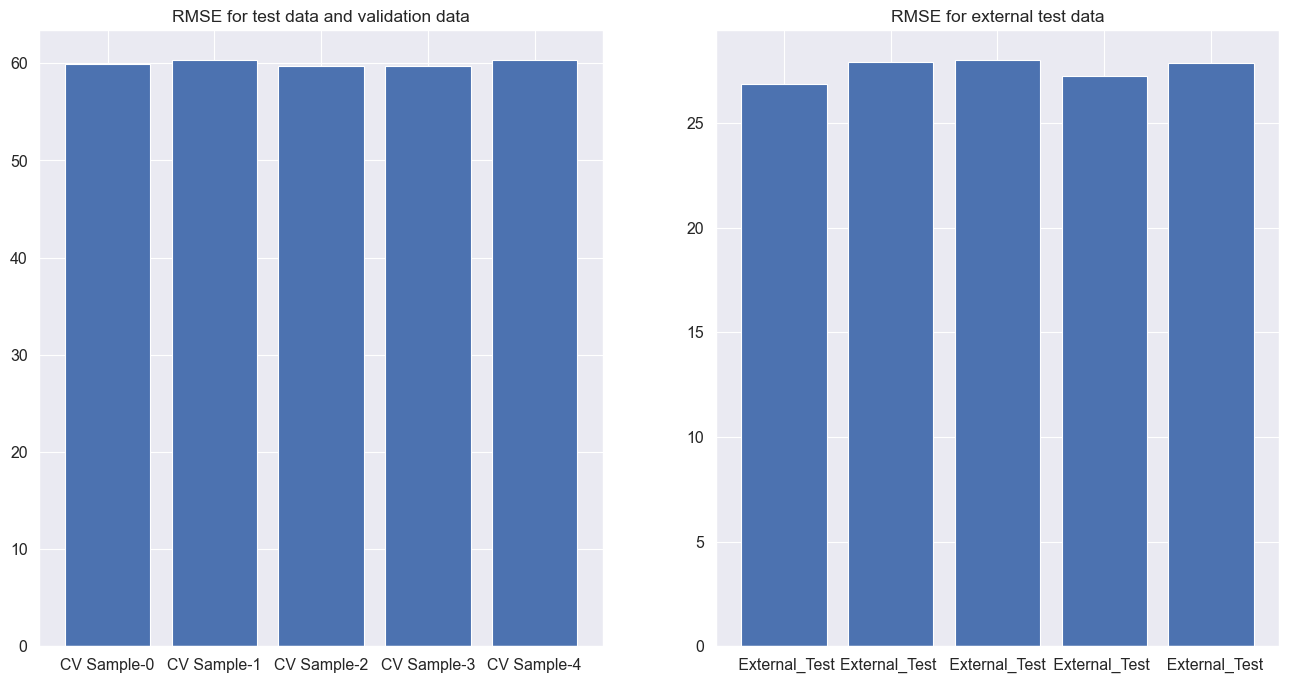

In [14]:
#initialize model
model_use = Lasso(random_state=1)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'lasso')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Ridge

Total number of input features: 314 , total number of selected features: 314
Combined cost on test and validation data is 30.149637609399782
Cost on external test data is 25.951608163578573


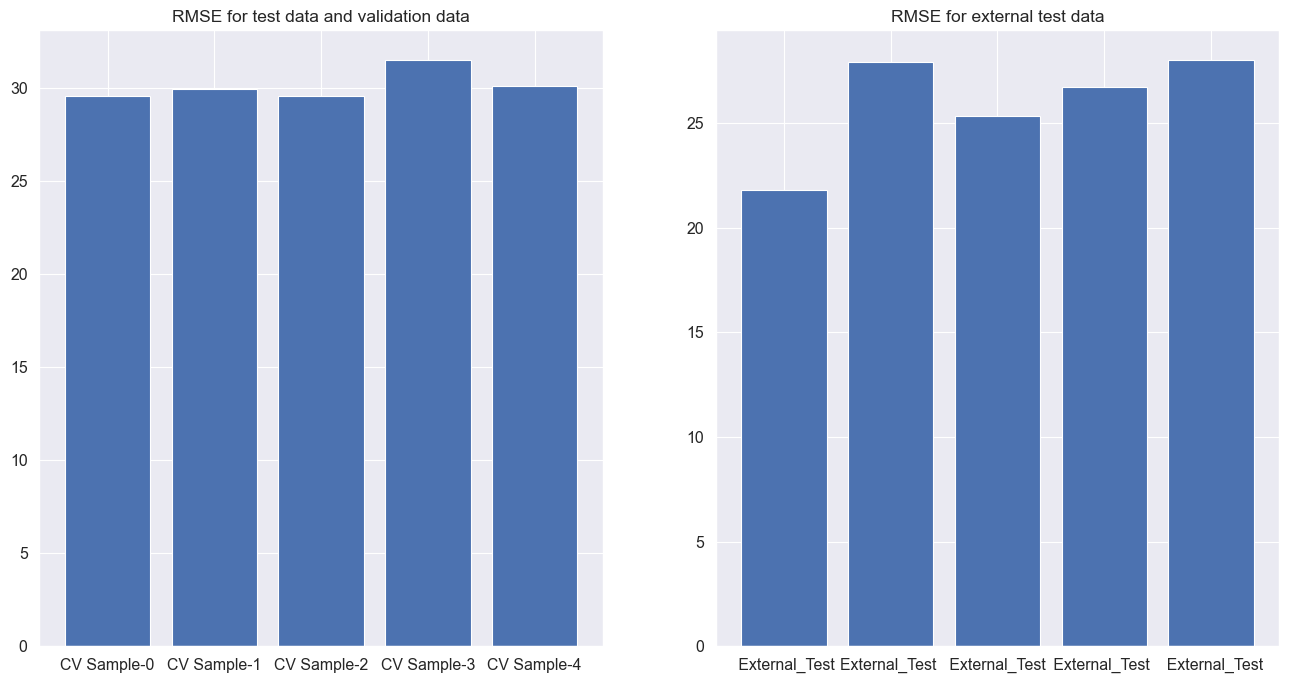

In [15]:
#initialize model
model_use = Ridge(random_state=1)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'ridge')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## ElasticNet

Total number of input features: 314 , total number of selected features: 314
Combined cost on test and validation data is 60.14067877088409
Cost on external test data is 27.56659885051197


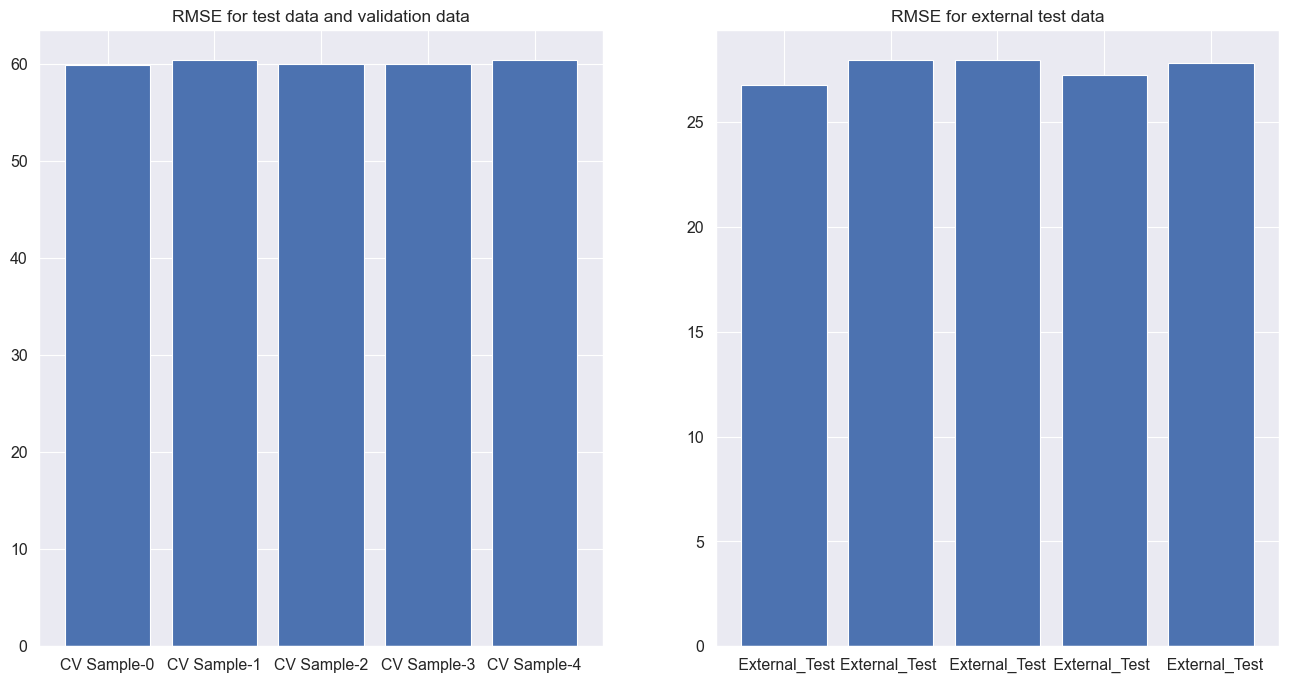

In [16]:
#initialize model
model_use = ElasticNet(random_state=1)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'elasticnet')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Linear Regression Weights

Total number of input features: 314 , total number of selected features: 17
Combined cost on test and validation data is 3453903703182.71
Cost on external test data is 2928233442328.2017


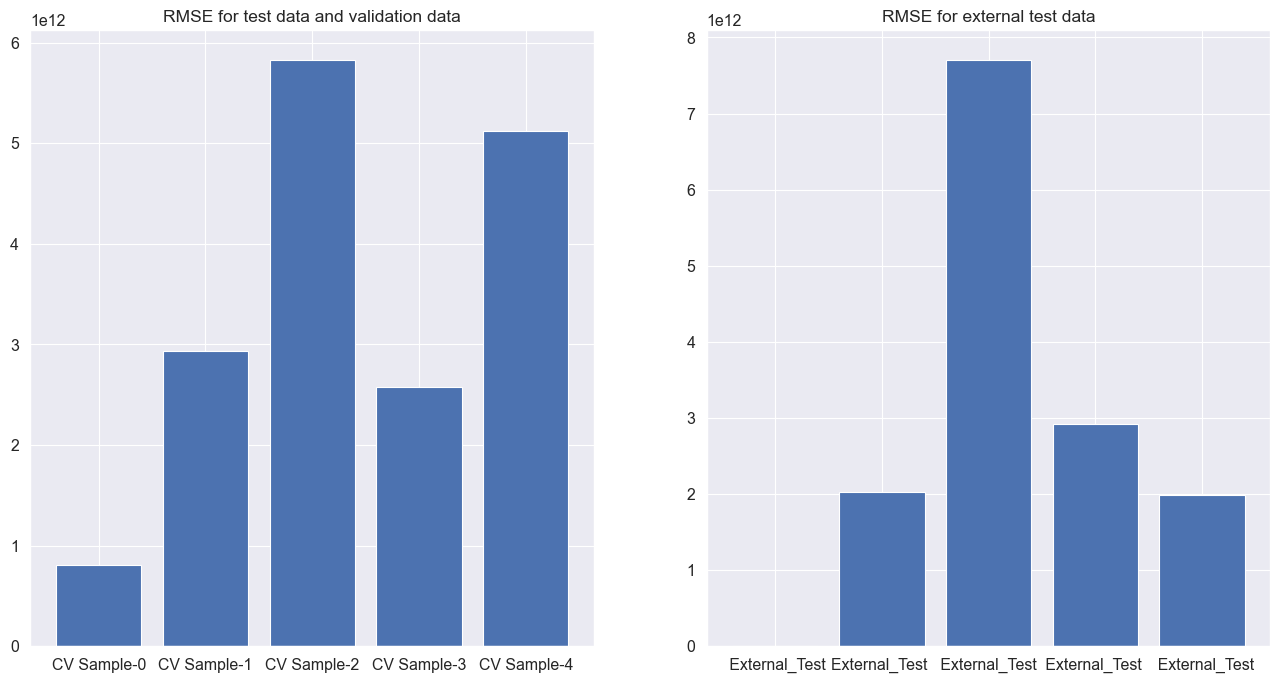

In [17]:
#initialize model
model_use = LinearRegression(n_jobs=-1)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = linear_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_linear,
                                                                           model = model_use,
                                                                           x_validation = x_validation_linear,
                                                                           y_validation = y_validation_linear,
                                                                           x_external = x_external_linear,
                                                                           y_external = y_external_linear,
                                                                           sequence = 'beta')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Tree Feature Importance - LightGBM

Total number of input features: 100 , total number of selected features: 22
Combined cost on test and validation data is 17.294388521132202
Cost on external test data is 12.325217421969429


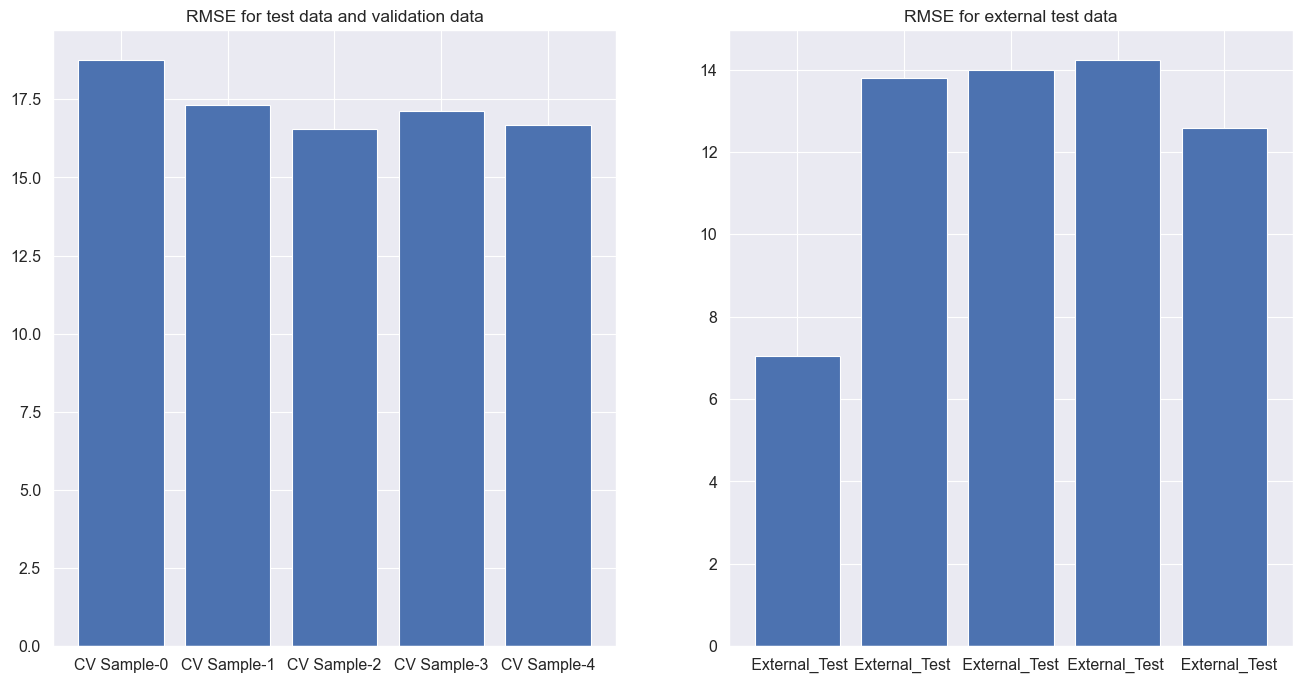

In [8]:
#initialize model
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'feature_importance')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Tree Feature Importance - XGboost

Total number of input features: 100 , total number of selected features: 6
Combined cost on test and validation data is 19.253476282857722
Cost on external test data is 14.569420191083484


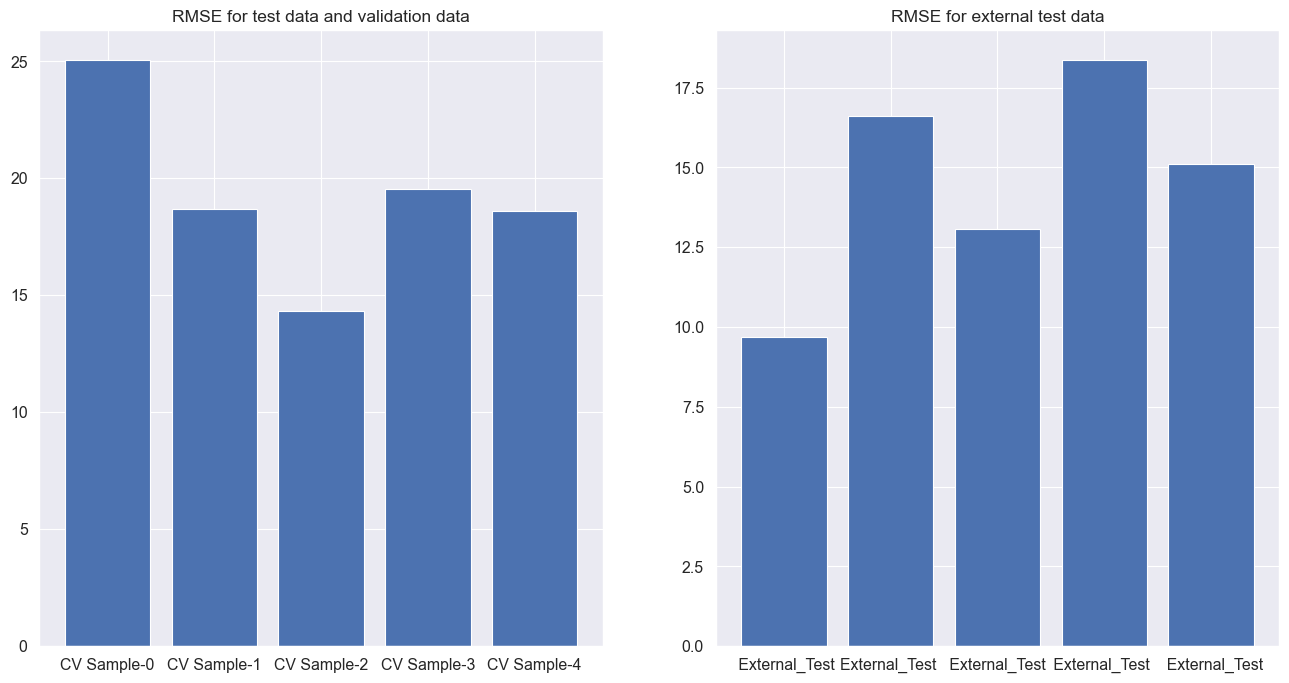

In [19]:
#initialize model
model_use = XGBRegressor(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'feature_importance')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Boruta - RandomForest

Total number of input features: 100 , total number of selected features: 88
Combined cost on test and validation data is 30.338116123055602
Cost on external test data is 10.95441916048139


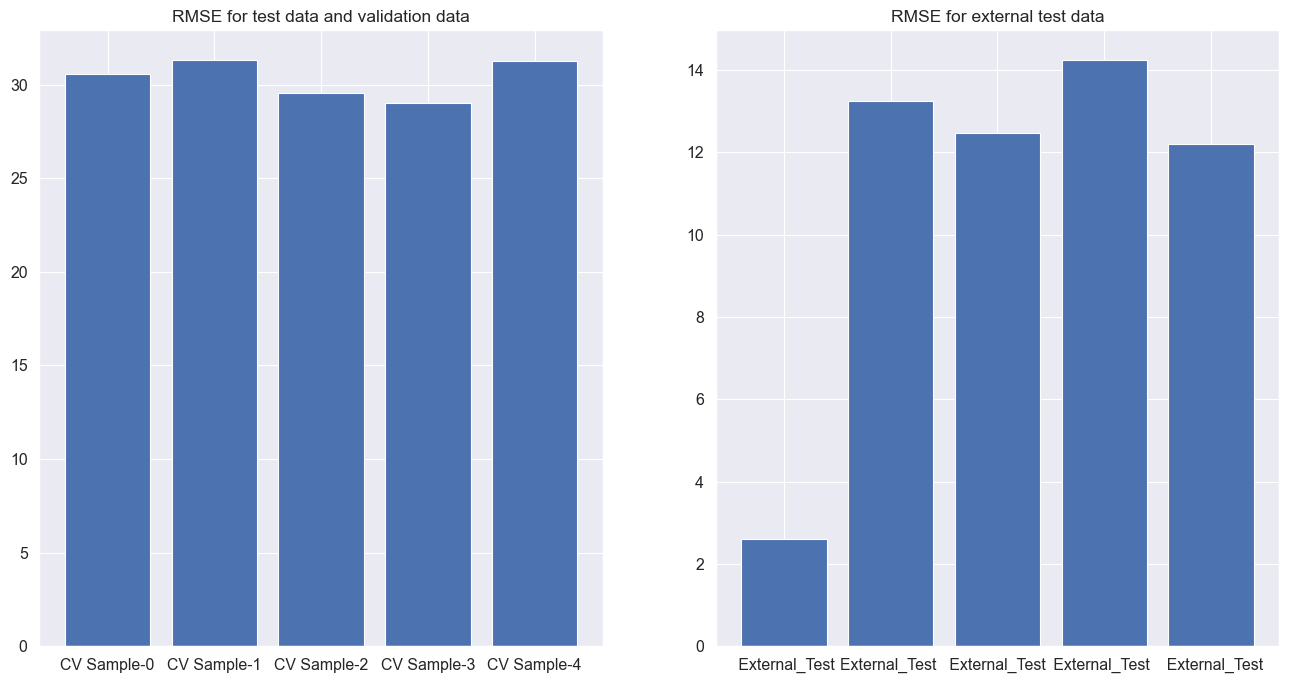

In [6]:
#initialize model
model_use = RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=200)

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'boruta')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)

## Boruta - Xgboost

Total number of input features: 100 , total number of selected features: 41
Combined cost on test and validation data is 17.29825329559428
Cost on external test data is 13.375030365406838


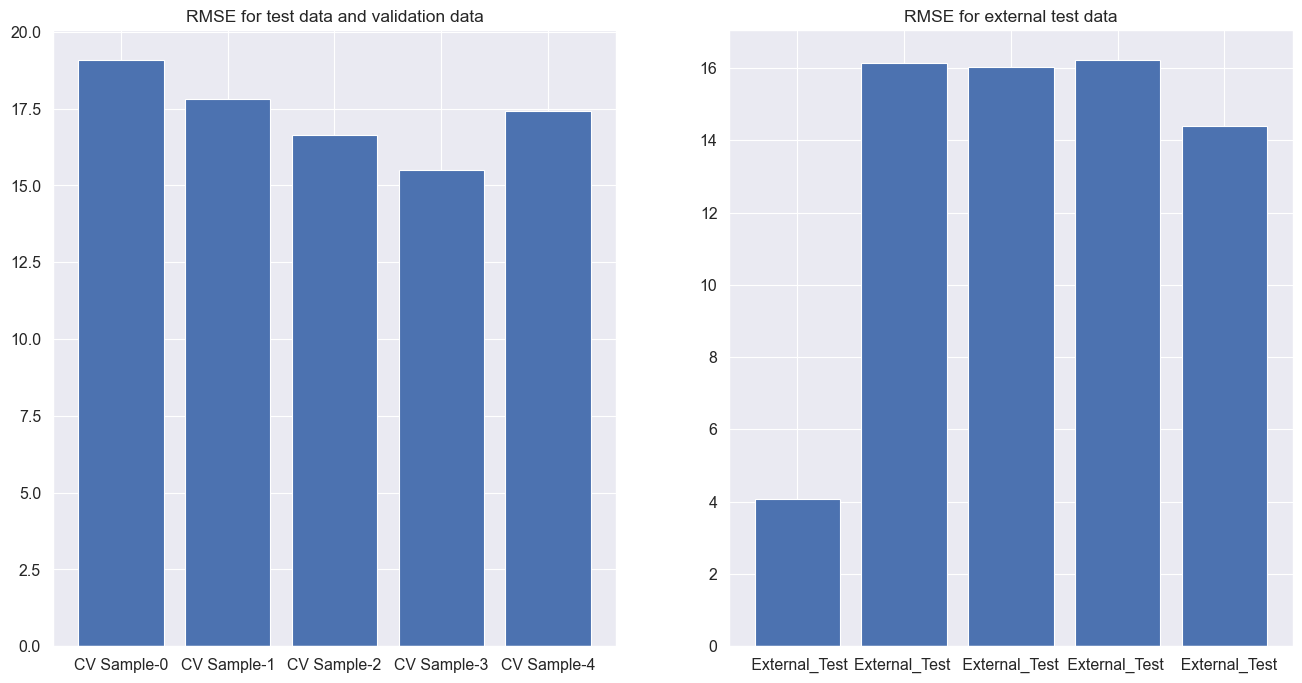

In [7]:
#initialize model
model_use = XGBRegressor(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')

#calculate cost
test_cost,external_cost,selected_features,common_features = calculate_cost(current_at_feature_subset = tree_features_all,
                                                                           problem_type = 'regression',
                                                                           cost_function = cost_funct,
                                                                           data_dict = data_dict_for_tree,
                                                                           model = model_use,
                                                                           x_validation = x_validation_tree,
                                                                           y_validation = y_validation_tree,
                                                                           x_external = x_external_tree,
                                                                           y_external = y_external_tree,
                                                                           sequence = 'boruta')
#make plot
make_plot(metric = 'RMSE',
          test_cost = test_cost,
          external_cost = external_cost)